In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
iteration_path = "iteration_3/"
deliveries_path = "../data/" + iteration_path + "raw/deliveries.jsonl"
products_path = "../data/" + iteration_path + "raw/products.jsonl"
sessions_path = "../data/" + iteration_path + "raw/sessions.jsonl"
users_path = "../data/" + iteration_path + "raw/users.jsonl"

In [4]:
deliveries_data = pd.read_json(deliveries_path, lines=True)
products_data = pd.read_json(products_path, lines=True)
sessions_data = pd.read_json(sessions_path, lines=True)
users_data = pd.read_json(users_path, lines=True)

In [5]:
sessions_data = sessions_data.sort_values(by=['timestamp'])
sessions_data['timestamp_date'] = sessions_data['timestamp'].apply(lambda x: x.date())
sessions_data['timestamp_week'] = sessions_data['timestamp'].apply(lambda x: x.week)
sessions_data['timestamp_month'] = sessions_data['timestamp'].apply(lambda x: x.month)
sessions_data['timestamp_quarter'] = sessions_data['timestamp'].apply(lambda x: x.quarter)

In [6]:
sessions_data['timestamp_interval'] = sessions_data['timestamp'].apply(lambda x: x.month)
sessions_data['timestamp_interval'] = sessions_data['timestamp'].apply(lambda x: x.month//2)

In [7]:
train_data = sessions_data[sessions_data['timestamp_interval'] < sessions_data['timestamp_interval'].max()]
test_data = sessions_data[sessions_data['timestamp_interval'] >= sessions_data['timestamp_interval'].max()]

In [8]:
train_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,timestamp_date,timestamp_week,timestamp_month,timestamp_quarter,timestamp_interval
5462,1615,2021-01-08 17:29:37,139,1032,VIEW_PRODUCT,10,NaN,2021-01-08,1,1,1,0
5463,1615,2021-01-08 17:32:51,139,1033,VIEW_PRODUCT,10,NaN,2021-01-08,1,1,1,0
5464,1615,2021-01-08 17:35:32,139,1033,BUY_PRODUCT,10,20833.0,2021-01-08,1,1,1,0
5544,1635,2021-01-10 05:56:20,139,1292,VIEW_PRODUCT,20,NaN,2021-01-10,1,1,1,0
5545,1635,2021-01-10 05:57:54,139,1291,VIEW_PRODUCT,20,NaN,2021-01-10,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14800,4208,2021-11-30 23:29:12,217,1035,VIEW_PRODUCT,15,NaN,2021-11-30,48,11,4,5
14801,4208,2021-11-30 23:33:41,217,1067,VIEW_PRODUCT,15,NaN,2021-11-30,48,11,4,5
13224,3779,2021-11-30 23:44:43,205,1084,VIEW_PRODUCT,0,NaN,2021-11-30,48,11,4,5
13225,3779,2021-11-30 23:47:34,205,1043,VIEW_PRODUCT,0,NaN,2021-11-30,48,11,4,5


In [9]:
def get_user_id_from_session(session):
    sample_user_id = session['user_id'].iloc[0]
    for user_id in session['user_id']:
        if sample_user_id != user_id:
            raise Exception("How it is even possible")
    return sample_user_id

In [10]:
def calculate_correlation_for_user(user_session_data, min_interval_value, max_interval_value):
    return {'correlation': calculate_expenses_with_interval(user_session_data, min_interval_value, max_interval_value).corr()['expenses']['interval_number'],
            'user_id': get_user_id_from_session(user_session_data)}

In [11]:
def calculate_expenses_with_interval(user_session_data, min_interval_value, max_interval_value):
    expenses=[]
    for interval in range (min_interval_value, max_interval_value + 1):
        d = {
            "interval_number": interval,
            "expenses": user_session_data[(user_session_data['timestamp_interval'] == interval) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()}
        expenses.append(d)
        # expenses.append(d['expenses'])

    df = pd.DataFrame(data=expenses)
    return df
    # df = df.set_index('month')

In [12]:
def plot_user_expenses(user_session_data, min_interval_value, max_interval_value):
    calculate_expenses_with_interval(user_session_data, min_interval_value, max_interval_value).set_index("interval_number").plot()

In [13]:
def collect_correlations(sessions_data, products_data):
    enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
    correlations = []
    min_value = sessions_data['timestamp_interval'].min()
    max_value = sessions_data['timestamp_interval'].max()
    for user_id in enriched_sessions_data['user_id'].unique():
        correlations.append(calculate_correlation_for_user(enriched_sessions_data[enriched_sessions_data['user_id'] == user_id], min_value, max_value))
    return pd.DataFrame(data=correlations)

In [14]:
collected_correlations = collect_correlations(sessions_data, products_data)
collected_correlations

,correlation,user_id
0,-0.532732,139
1,-0.507557,242
2,-0.115067,108
3,-0.085081,143
4,0.028252,140
...,...,...
195,NaN,289
196,0.408248,225
197,NaN,152
198,0.408248,162


<AxesSubplot:ylabel='Frequency'>

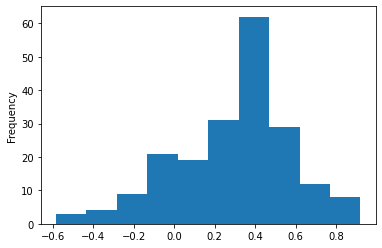

In [15]:
collected_correlations['correlation'].plot.hist()

# Trenowanie

#### Ekstrakcja szeregów

In [16]:
def calculate_expenses_with_interval(user_session_data, min_interval_value, max_interval_value):
    expenses=[]
    for interval in range (min_interval_value, max_interval_value + 1):
        d = {
            "interval_number": interval,
            "expenses": user_session_data[(user_session_data['timestamp_interval'] == interval) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()}
        expenses.append(d)
        # expenses.append(d['expenses'])

    df = pd.DataFrame(data=expenses)
    return df
    # df = df.set_index('month')

In [17]:
def extract_time_series(sessions_data, products_data):
    enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
    users_time_series = []
    min_value = sessions_data['timestamp_interval'].min()
    max_value = sessions_data['timestamp_interval'].max()
    for user_id in enriched_sessions_data['user_id'].unique():
        users_time_series.append(
            {
                "user_id":user_id,
                "expenses": calculate_expenses_with_interval(enriched_sessions_data[enriched_sessions_data['user_id'] == user_id], min_value, max_value)
            }
        )
    return users_time_series

In [18]:
extract_time_series(sessions_data, products_data)

[{'user_id': 139,
  'expenses':    interval_number  expenses
  0                0   8568.86
  1                1    571.15
  2                2   3124.85
  3                3   8090.99
  4                4    773.58
  5                5   2271.42
  6                6      0.00},
 {'user_id': 242,
  'expenses':    interval_number  expenses
  0                0   5360.87
  1                1   9209.44
  2                2  20744.74
  3                3   2469.82
  4                4   4412.35
  5                5   2320.96
  6                6    158.96},
 {'user_id': 108,
  'expenses':    interval_number  expenses
  0                0    354.00
  1                1   2368.79
  2                2   6593.62
  3                3    298.78
  4                4   4730.88
  5                5   1965.96
  6                6      0.00},
 {'user_id': 143,
  'expenses':    interval_number  expenses
  0                0    193.80
  1                1   2328.90
  2                2    553.00
  3   

#### Predykcja (model bazowy)

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [20]:
def predict_expenses_for_user(time_series):
    model = LinearRegression()
    model.fit(time_series['interval_number'].values.reshape(-1,1), time_series['expenses'].values.reshape(-1,1))
    return max(model.predict((time_series['interval_number'].max() + 1).reshape(1,-1))[0,0], 0)

In [21]:
def predict_expenses_for_all_users(sessions_data, products_data):
    extracted_time_series = extract_time_series(sessions_data, products_data)
    user_future_expenses = []
    for record in extracted_time_series:
        user_future_expenses.append({
            "user_id":record["user_id"],
            "user_expenses": predict_expenses_for_user(record["expenses"])
        })
    return pd.DataFrame(data=user_future_expenses).set_index('user_id')

In [22]:
predictions = predict_expenses_for_all_users(sessions_data, products_data)

In [23]:
# enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
# user_session_data = enriched_sessions_data[enriched_sessions_data['user_id'] == 104]
# ex_time_series = calculate_expenses_with_interval(user_session_data, 1, 12)
# predict_expenses_for_user(ex_time_series)
# # print(ex_time_series['expenses'].values.reshape(-1,11))

# Testowanie

In [24]:
def get_user_expenses(user_session_data):
    d = {
        'user_id': get_user_id_from_session(user_session_data),
        'expenses': user_session_data[user_session_data['event_type'] == "BUY_PRODUCT"]['price'].sum()
    }
    # df = pd.DataFrame(data=d)
    return d

In [25]:
def calculate_expenses(sessions_data, products_data, users_data):
    enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
    user_expenses = []
    for user_id in range(users_data['user_id'].min(), users_data['user_id'].max()+1):
    # for user_id in enriched_sessions_data['user_id'].unique():
        user_session_data = enriched_sessions_data[enriched_sessions_data['user_id'] == user_id]
        user_expenses.append(
            {
                'user_id': user_id,
                'expenses': user_session_data[user_session_data['event_type'] == "BUY_PRODUCT"]['price'].sum()
            }
        )
        # user_expenses.append(get_user_expenses(enriched_sessions_data[enriched_sessions_data['user_id'] == user_id]))
    return pd.DataFrame(data=user_expenses).set_index('user_id')

In [26]:
def loss(predictions, observations):
    unified_data = pd.merge(predictions, observations, on="user_id").sort_values(by=['user_id'])
    unified_data['difference'] = unified_data['user_expenses'] - unified_data['expenses']
    unified_data['difference_square'] = unified_data['difference'].apply(lambda x: x**2)
    return unified_data

In [27]:
observations = calculate_expenses(test_data, products_data, users_data)

In [28]:
observations

,expenses
user_id,
102,0.00
103,554.77
104,2332.01
105,0.00
106,0.00
...,...
297,109.00
298,2399.00
299,0.00


In [275]:
predictions = predictions.sort_values(by = ['user_id'])
predictions

,user_expenses
user_id,
102,141.385714
103,5808.132857
104,7002.714286
105,798.478571
106,5053.444286
...,...
297,2683.224286
298,5587.500000
299,3832.368571


In [277]:
loss(predictions, observations).mean()

user_expenses        3.027884e+03
expenses             6.562526e+02
difference           2.371631e+03
difference_square    1.091033e+07
dtype: float64

# Podgląd danych

In [91]:
enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
user_session_data = enriched_sessions_data[enriched_sessions_data['user_id'] == 139]
user_session_data[(user_session_data['timestamp_interval'] == 1) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()

8568.86

In [92]:
ex_time_series = calculate_expenses_with_interval(user_session_data, 1, 12)
ex_time_series

,interval_number,expenses
0,1,8568.86
1,2,496.26
2,3,74.89
3,4,2763.88
4,5,360.97
5,6,4893.80
6,7,3197.19
7,8,708.78
8,9,64.80
9,10,911.96


In [93]:
calculate_correlation_for_user(user_session_data, 1, 12)

{'correlation': -0.46327522997316334, 'user_id': 139}

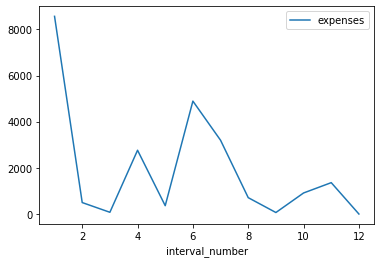

In [94]:
plot_user_expenses(user_session_data, 1, 12)